# Exploring Hoffman Stochastic VI

In [89]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from copy import deepcopy

from valez_finite_VI_lib import *


# Draw data

In [90]:
np.random.seed(43141) 
Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP

alpha = 10 # IBP parameter

# Parameters to draw A from MVN
sigma_eps = .1 # variance of noise
sigma_A = 100

# generate data
Pi, Z, mu, A, X = generate_data(Num_samples, D, K_inf, sigma_A, sigma_eps, alpha)



# Set initializations 

In [98]:
# set initializations
K_approx = deepcopy(K_inf) # variational truncation
tau, nu, phi_mu, phi_var = initialize_parameters(Num_samples, D, K_approx)

Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': sigma_eps, 'A': sigma_A}



# run stochastic VI

In [101]:
iterations = 1000
elbo = np.zeros(iterations)

batch_size = Num_samples / 100
assert batch_size % 1 == 0  # make sure this is an integer
batch_size = int(batch_size)

step_size = 1
iter_ran = 0

for i in range(iterations): 
    # sample data
    indices = np.random.choice(Num_samples, size = batch_size, replace = False)
    
    # update local parameters: in this case, nu
    digamma_tau = sp.special.digamma(tau)
    for n in indices: 
        for k in range(K_approx): 
            nu_updates(tau, nu, phi_mu, phi_var, X, sigmas, n, k, digamma_tau)
    
    
    # replicate data
    replicates = Num_samples/batch_size 
    # the method below will only work when Num_samples is a multiple of batch_size
    assert Num_samples%batch_size == 0 
    
    replicates = int(replicates)
    
    nu_stochastic = np.zeros((Num_samples, K_approx))
    X_stochastic = np.zeros((Num_samples, D))
    for j in range(batch_size): 
        nu_stochastic[j*replicates:(j+1)*replicates , :] = nu[indices[j], :]
        X_stochastic[j*replicates:(j+1)*replicates , :] = X[indices[j], :]
    
    """ print(nu[indices, :])
        print(X[indices, :])
        print(nu_stochastic)
        print(X_stochastic)
    """ 
        
    # update global paremeters: phi_mu, phi_var, and tau
    phi_mu_old = deepcopy(phi_mu)
    phi_var_old = deepcopy(phi_var)
    tau_old = deepcopy(tau)

    for k in range(K_approx): 
        phi_updates(nu_stochastic, phi_mu, phi_var, X_stochastic, sigmas, k)
        
    for k in range(K_approx): 
        tau_updates(tau, nu_stochastic, alpha)
        
    
    # compute step-size
    """if step_size < 10**(-4): 
        step_size = 10**(-1)
    else: 
        step_size = 1/(1/step_size+1)
    """
    stepsize = (iter_ran+1)**(-0.9)
    
    # update global parameters
    phi_mu = phi_mu_old * (1-step_size) + phi_mu * step_size
    phi_var = phi_var_old * (1-step_size) + phi_var * step_size
    tau = tau_old * (1-step_size) + tau * step_size
    
    total_iter = total_iter + 1
    
    elbo[i] = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, alpha)[0]

    print('iteration: ', i, ' l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]), 'elbo: ', elbo[i])
    
    #if np.abs(elbo[i]-elbo[i-1]) <= 10**(-8) and np.abs(elbo[i-1]-elbo[i-2]) <= 10**(-8):
    #    print('ELBO converged')
    #    break
    
    iter_ran = iter_ran+1

iteration:  0  l1 error:  0.774279611186 elbo:  -267653.68873
iteration:  1  l1 error:  0.774279611186 elbo:  -267653.68873
iteration:  2  l1 error:  0.774279611186 elbo:  -267653.68873
iteration:  3  l1 error:  0.774279611186 elbo:  -267653.68873
iteration:  4  l1 error:  0.776154241266 elbo:  -263845.078658
iteration:  5  l1 error:  0.776154241266 elbo:  -263845.078658
iteration:  6  l1 error:  0.776154241266 elbo:  -263845.078658
iteration:  7  l1 error:  0.775689291431 elbo:  -262537.399543
iteration:  8  l1 error:  0.775712874985 elbo:  -261354.190979
iteration:  9  l1 error:  0.776309797231 elbo:  -258706.040007
iteration:  10  l1 error:  0.776309797231 elbo:  -258706.040007
iteration:  11  l1 error:  0.777228844547 elbo:  -257321.254061
iteration:  12  l1 error:  0.778551976834 elbo:  -255327.691257
iteration:  13  l1 error:  0.780543718307 elbo:  -252327.881467
iteration:  14  l1 error:  0.780543718307 elbo:  -252327.881467
iteration:  15  l1 error:  0.780543718307 elbo:  -2523

Z (unpermuted): 
 [[1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 1]
 [1 1 1]]
** procedure did not give a true permutation
permutation:  [2, 1, 0]
Z (permuted) 
 [[1 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]]
round_nu 
 [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
l1 error (after permutation):  [0.79800000000000004, 0.81999999999999995, 0.81999999999999995]


true A (permuted): 
 [[ 1.1894611  -8.60276614]
 [ 9.54417571  3.59640607]
 [-3.07199514  5.0220693 ]]
phi_mu: 
 [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


true Pi (permuted):  [ 0.8  0.8  0.8]
computed Pi:  [ 0.00660939  0.00660939  0.00660939]


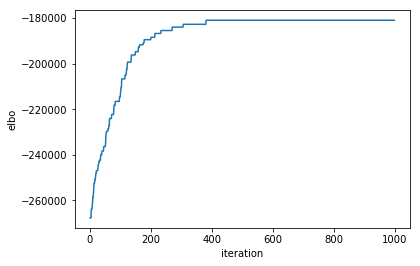

In [102]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
print('Z (unpermuted): \n', Z[0:10])

# Find the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
perm_tmp = np.argmin(accuracy_mat, 1)

# check that we have a true permuation
if len(perm_tmp) == len(set(perm_tmp)):  
    perm = perm_tmp
else: 
    print('** procedure did not give a true permutation')
    perm = [2,1,0]

print('permutation: ', perm)
    
# print Z (permuted) and nu
print('Z (permuted) \n', Z[0:10, perm])
print('round_nu \n', round_nu[0:10,:])

print('l1 error (after permutation): ', \
    [ np.sum(np.abs(Z[:, perm[i]] - nu[:, i]))/Num_samples for i in range(K_inf) ])

print('\n')
print('true A (permuted): \n', A[perm, :])
print('phi_mu: \n', phi_mu.transpose())

print('\n')
print('true Pi (permuted): ', Pi)
print('computed Pi: ', Pi_computed)
plt.clf()
plt.plot(elbo[:iter_ran])
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()